In [1]:
from __future__ import division
import pathlib, os, sys, traceback
import numpy as np
import cv2, pygame, scipy, h5py
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import argparse
import numpy as np
#import multiprocessing as mp
from collections import Counter

from synthgen import *
from common import *


%load_ext autoreload
%autoreload 2

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## DeepLabV3 semseg (useless for synthtext?)

In [2]:
filename = 'seg_inputs/sample0.jpg' # WORKS for this img because only 2 labels were detected
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

#model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
segments = output.argmax(0)

Using cache found in /home/gota/.cache/torch/hub/pytorch_vision_v0.8.0


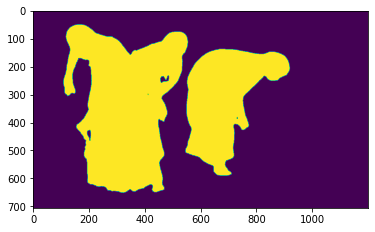

In [3]:
plt.imshow(segments.cpu().numpy())

3 (706, 1200)


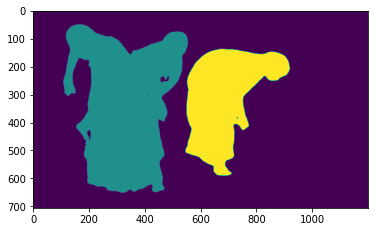

In [5]:
# Get separated labels with cv2.connectComponents
img = segments.cpu().numpy().astype(np.uint8)
n_labels, results = cv2.connectedComponents(img)
print(n_labels, results.shape)
plt.imshow(results)

In [6]:
# Then calculate areas / labels
segments = results

areas = []
labels = []
if isinstance(segments, torch.Tensor):
    segments = segments.cpu().numpy()

for i, v in enumerate(np.unique(segments)):
    areas.append(len(segments[segments==v]))
    ###labels.append(i)
    labels.append(v)
(areas, labels)

([586610, 169322, 91268], [0, 1, 2])

## Contour detection + floodfill (NOT WORTH IT)
Skip to the Depth section

### Contour detection

In [5]:
from __future__ import print_function

import argparse
import os
import time, platform

import cv2
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from DexiNed.datasets import DATASET_NAMES, BipedDataset, TestDataset, dataset_info
from DexiNed.losses import *
from DexiNed.model import DexiNed
# from model0C import DexiNed
from DexiNed.utils import (image_normalization, save_image_batch_to_disk,
                   visualize_result)


In [13]:
def test(checkpoint_path, dataloader, model, device, output_dir, args):
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(
            f"Checkpoint filte note found: {checkpoint_path}")
    print(f"Restoring weights from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path,
                                     map_location=device))

    # Put model in evaluation mode
    model.eval()

    with torch.no_grad():
        total_duration = []
        for batch_id, sample_batched in enumerate(dataloader):
            images = sample_batched['images'].to(device)
            if not args.test_data == "CLASSIC":
                labels = sample_batched['labels'].to(device)
            file_names = sample_batched['file_names']
            image_shape = sample_batched['image_shape']
            print(f"input tensor shape: {images.shape}")
            # images = images[:, [2, 1, 0], :, :]
            start_time = time.time()
            preds = model(images)
            print(len(preds), preds[0].shape)
            
            tmp_duration = time.time() - start_time
            total_duration.append(tmp_duration)
            save_image_batch_to_disk(preds,
                                     output_dir,
                                     file_names,
                                     image_shape,
                                     arg=args)
            torch.cuda.empty_cache()

    total_duration = np.array(total_duration)
    print("******** Testing finished in", args.test_data, "dataset. *****")
    print("Average time per image: %f.4" % total_duration.mean(), "seconds")
    print("Time spend in the Dataset: %f.4" % total_duration.sum(), "seconds")

In [40]:
%ls

checkpoints/              LICENSE                 results/
colorize3_poisson.py      output0.png             samples.png
common.py                 poisson_reconstruct.py  seg_inputs/
data/                     prep_scripts/           seg_sample0.h5
DexiNed/                  __pycache__/            synthgen.py
explore_synthtext2.ipynb  ransac.py               synth_utils.py
explore_synthtext.ipynb   README.md               text_utils.py
gen.py                    realtime_panoptic/      Untitled.ipynb
invert_font_size.py       requirements.txt        visualize_results.py


In [9]:
# Argparse vars
input_val_dir = 'seg_inputs'
test_data = 'CLASSIC'
test_img_width = 512
test_img_height = 512
mean_pixel_values = [103.939,116.779,123.68, 137.86]
test_list = None
num_workers = 4


tb_writer = None
#training_dir = os.path.join(args.output_dir,args.train_data)
#os.makedirs(training_dir, exist_ok=True)
#checkpoint_path = os.path.join(args.output_dir, args.train_data, args.checkpoint_data)



# Get computing device
device = torch.device('cpu' if torch.cuda.device_count() == 0
                      else 'cuda')

# Instantiate model and move it to the computing device
model = DexiNed().to(device)
# model = nn.DataParallel(model)
ini_epoch = 0

dataset_val = TestDataset(input_val_dir,
                          test_data=test_data,
                          img_width=test_img_width,
                          img_height=test_img_height,
                          mean_bgr=mean_pixel_values[0:3] if len(
                              mean_pixel_values) == 4 else mean_pixel_values,
                          test_list=test_list, arg=None
                          )
dataloader_val = DataLoader(dataset_val,
                            batch_size=1,
                            shuffle=False,
                            num_workers=num_workers)


mean_bgr: [103.939, 116.779, 123.68]


In [15]:
output_dir = 'checkpoints'
checkpoint_data = '14/14_model.pth'
train_data = 'BSDS'
checkpoint_path = os.path.join('DexiNed', output_dir, train_data, checkpoint_data)


class Args:
    test_data = 'CLASSIC'
    is_testing = True

args = Args()

test(checkpoint_path, dataloader_val, model, device, output_dir, args=args)

Restoring weights from: DexiNed/checkpoints/BSDS/14/14_model.pth
actual size: (706, 1200, 3), target size: (512, 512)
input tensor shape: torch.Size([1, 3, 512, 512])
7 torch.Size([1, 1, 512, 512])
******** Testing finished in CLASSIC dataset. *****
Average time per image: 0.009982.4 seconds
Time spend in the Dataset: 0.009982.4 seconds


In [20]:
%ls checkpoints/fused

sample0.png


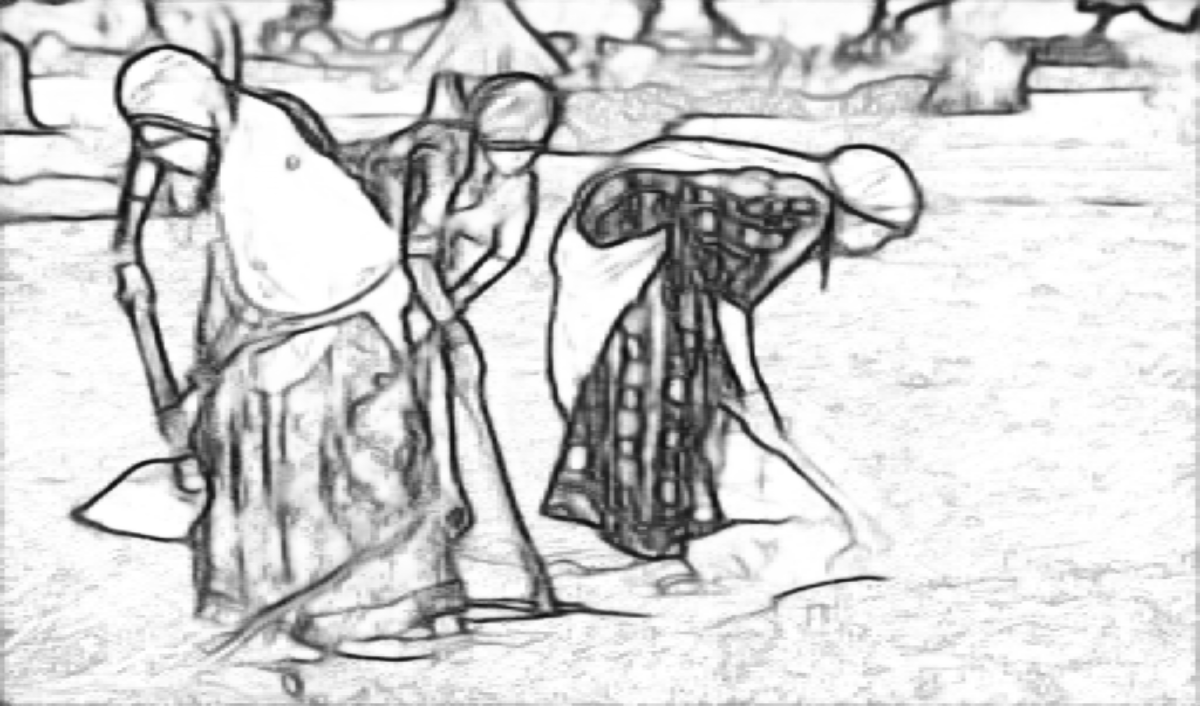

In [75]:
from IPython.display import Image as JImage
#binary_img_path = 'checkpoints/fused/sample0.png'
binary_img_path = 'checkpoints/avg/sample0.png'
JImage(filename=binary_img_path)

### FloodFill

(706, 1200)


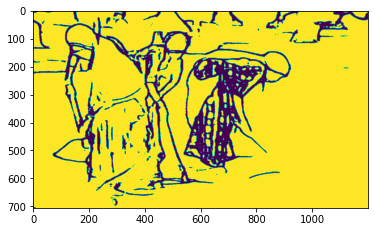

In [80]:
img = np.array(Image.open(binary_img_path))
print(img.shape)
ucm = img.copy()
#print(ucm)
#print(np.where(ucm==0))

ucm[ucm < 125] = 0
ucm[ucm > 126] = 255
plt.imshow(ucm)

(0, 0)
  > terminated in 124 steps


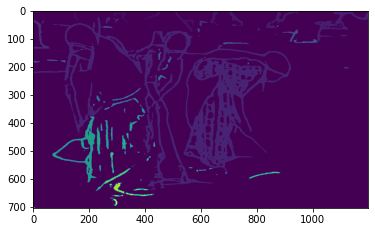

In [81]:
def get_seed(sx,sy,ucm):
    n = sx.size
    #print(n, len(sx), len())
    for i in range(n):
        if ucm[sx[i]+1,sy[i]+1] == 0:
            return (sy[i],sx[i])






h,w = ucm.shape[:2]
mask = np.zeros((h-2,w-2),'float32')

i = 0
sx,sy = np.where(mask==0)
seed = get_seed(sx,sy,ucm)
print(seed)
areas = []
labels = []
while seed is not None and i < 1000:
    cv2.floodFill(mask,ucm,seed,i+1)
    # calculate the area (no. of pixels):
    areas.append(np.sum(mask==i+1))
    labels.append(i+1)

    # get the location of the next seed:
    sx,sy = np.where(mask==0)
    seed = get_seed(sx,sy,ucm)
    i += 1
print("  > terminated in %d steps"%i)

plt.imshow(mask)

In [82]:
np.unique(mask)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124.], dtype=float32)

## Depth

In [7]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /home/gota/.cache/torch/hub/intel-isl_MiDaS_master


In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /home/gota/.cache/torch/hub/intel-isl_MiDaS_master


/home/gota/.cache/pypoetry/virtualenvs/synthtext-sapplex-_8ARnqH5-py3.8/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


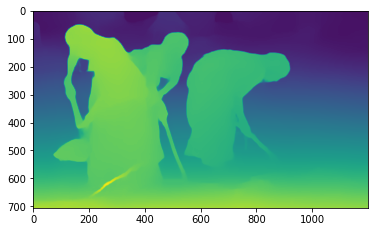

In [9]:
#filename = 'seg_inputs/sample0.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth = prediction.cpu().numpy()
plt.imshow(depth)

# Run SynthText

(706, 1200)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] [[0.4298698  0.41541418 0.39433676 ... 0.         0.         0.        ]
 [0.40406355 0.4016949  0.39857998 ... 0.         0.         0.        ]
 [0.3685517  0.383114   0.40514472 ... 0.         0.         0.        ]
 [0.37719697 0.38989928 0.4089876  ... 0.         0.         0.        ]
 [0.41291755 0.41271093 0.4124459  ... 0.         0.         0.        ]]
(706, 1200)
(1200, 706)
(706, 1200)
GET_TEXT_PLACEMENT_MASK
7 (37, 2) [203. 426.]
PLACE_MASK:
(40, 6) [255]
(40, 6) [  0 255]
(706, 1200)
GET_TEXT_PLACEMENT_MASK
4 (1035, 2) [158.  48.]
PLACE_MASK:
(560, 417) [255]
(560, 417) [  0 255]


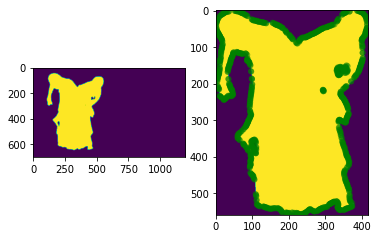

(706, 1200)
GET_TEXT_PLACEMENT_MASK
2 (632, 2) [667. 136.]
PLACE_MASK:
(415, 256) [255]
(415, 256) [  0 255]


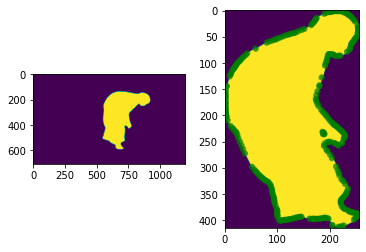

2
Found 2 text regions.
reg_idx [0 1]
Choose the region index0
self.max_shrink_trials 5
Type your textSapplex
DEBUG text_mask 00 (560, 417)
DEBUG collision_mask 00 (560, 417)


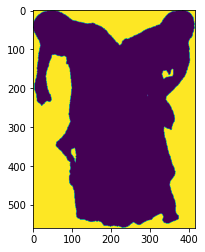

DEBUG text_mask 1 (706, 1200)
(array([396, 396, 396, ..., 455, 455, 455]), array([271, 272, 273, ..., 342, 343, 344]))


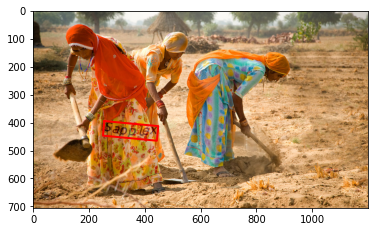

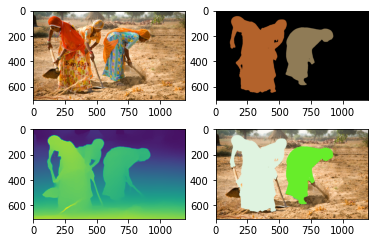

--------------------------------------------------
1


In [10]:
#seg = mask
seg = segments
print(seg.shape)

#depth = output
img = Image.open(filename)
print(seg[:5], depth[:5])
area = np.array(areas)
label = np.array(labels)
INSTANCE_PER_IMAGE = 5

# re-size uniformly:
#depth = depth[:704, :1198]
depth = depth[:seg.shape[0], :seg.shape[1]]
print(depth.shape)
sz = depth.shape[:2][::-1]
print(sz) # (1200, 706)
img = np.array(img.resize(sz, Image.ANTIALIAS))
##seg = np.array(Image.fromarray(seg).resize(sz, Image.NEAREST))
segr = cv2.resize(seg, sz, interpolation=cv2.INTER_NEAREST)

DATA_PATH = 'data'
SECS_PER_IMG = 1
viz = False

RV3 = RendererV3(DATA_PATH,max_time=SECS_PER_IMG)
#print(colorize(Color.RED,'%d of %d'%(i,end_idx-1), bold=True))
#res = RV3.render_text(img, depth, seg, area,label,
res = RV3.render_text_interactive(img, depth, seg, area,label,
                    #ninstance=INSTANCE_PER_IMAGE,viz=viz)
                    ninstance=1, viz=True)
print('-'*50)
print(len(res))
#plt.imshow(res)

In [11]:
#res[0]['wordBB']
#res[0]['charBB']
print(res[0]['wordBB'].shape, res[0]['charBB'].shape)

(2, 4, 1) (2, 4, 7)


dict_keys(['img', 'charBB', 'wordBB', 'txt']) (706, 1200, 3)
['Sapplex']


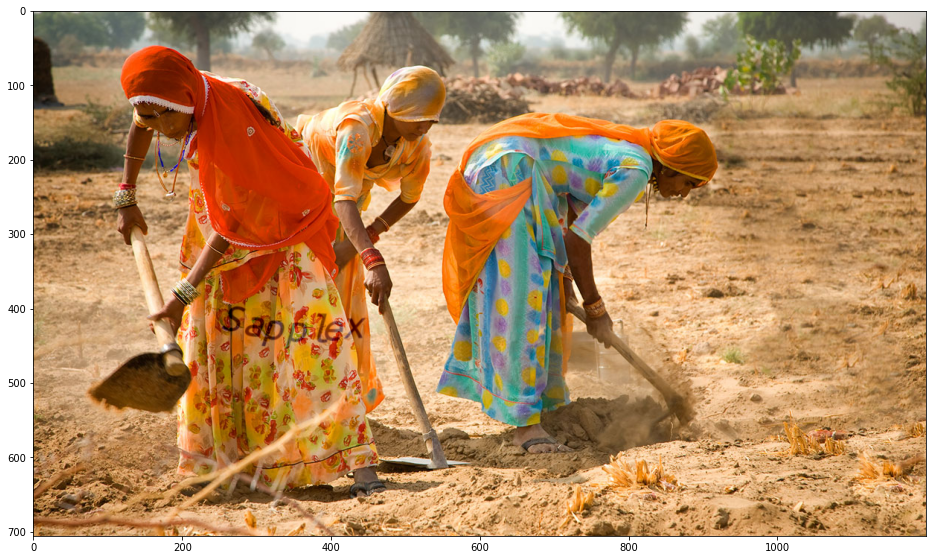

In [12]:
vis_index = 0
print(res[vis_index].keys(), res[vis_index]['img'].shape) 
fig = plt.figure(figsize=(16,16))
plt.imshow(res[vis_index]['img'])
print(res[vis_index]['txt'])